# [IAPR][iapr]: Lab 3 ‒  Classification


**Group ID:** xx

**Author 1 (sciper):** Valérie Costa (315855)  
**Author 2 (sciper):** Jennifer Abou-Najm (312656)   
**Author 3 (sciper):** Arthur Wuhrmann (344752)   

**Release date:** 19.04.2023  
**Due date:** 05.05.2023 


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as
preparation for the final project, which is a practical project which ties together the topics of the course.

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external
functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation
in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook <font color='red'> rerun </font>the notebook from scratch !**
`Kernel` > `Restart & Run All`

We will not rerun the notebook for you.


[iapr]: https://github.com/LTS5/iapr

--
## 0. Setup

In [1]:
%load_ext autoreload
%autoreload 2

In this lab, we will use PyTorch. If you are not familiar with this library, [here](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html) is a quick tutorial of the basics.

In [2]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-03-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1 - Out-of-Distribution detection in colorectal cancer histology (12 points)

Colorectal cancer is one of the most widespread cancers for men and women. Diagnosis complemented with prognostic and predictive biomarker information is essential for patient monitoring and applying personalized treatments. A critical marker is the tumor/stroma ratio in unhealthy tissues sampled from the colon. The higher the ratio, the more invasive the cancer is. The degree of invasion is tightly linked to patient survial probability.

To measure the ratio, a pathologist needs to analyze the unhealthy tissue under a microscope and estimate it from a look. As the number of samples to analyze is huge and estimations are only sometimes precise, automatic recognition of the different tissue types in histological images has become essential. Such an automatic process requires the development of a multi-class classifier to identify the numerous tissues. As shown below, they are usually 8 tissue types to categorize: TUMOR, STROMA, LYMPHO (lymphocytes), MUCOSA, COMPLEX (complex stroma), DEBRIS, ADIPOSE and EMPTY (background).

<br />
<br />
<figure>
    <img src="../data/lab-03-data/part1/kather16.svg" width="1100">
    <center>
    <figcaption>Fig1: Collection of tissue types in colorectal cancer histology (Kather-16)</figcaption>
    </center>
</figure>
<br />
<br />


Up to this day, state-of-the-art methods use deep-learning-based supervised learning methods. A downfall of such an approach is the necessity to access a well-annotated training dataset. In histology, annotating data is difficult. It is time-consuming and requires the expertise of pathologists. Moreover, the annotator must label every tissue type while only two (TUMOR and STROMA) are interesting. 


Consequently, we propose another approach. In order to make the annotation task less tedious, we ask the annotator to label only the tissues of interest and dump the others. Then, we must train a binary classifier to automatically recognize these tissues at test time. In this part, you will implement the proposed approach.

### 1.1 Binary classifier with Mahalanobis distance (3 points)

Based on the abovementioned process, your task is to build a model that recognizes TUMOR (Label 0) and STROMA (Label 1) tissue types. Your model will be supervised by a training dataset containing TUMOR and STROMA annotations; note that all other tissues have been dropped.
We will not ask you to train a deep-learning-based binary classifier from scratch. Instead, we provide excellent features (descriptors) of the images we extracted from a visual foundation model. (Note: As the nature of the foundation model is not part of this lecture, feel free to ask TAs if you are curious).

Run the cell below to extract the provided train and test dataset. Each image is represented by a 768-d feature vector extracted from a visual foundation model. The train and test datasets contain feature vectors of 878 and 186 images respectively.

In [3]:
import torch 
import sklearn
import numpy as np


# Label mapping
label_to_classname = {0 : "TUMOR", 1 : "STROMA"}

# Train features and labels
train_features = torch.load(os.path.join(data_base_path, data_folder, "part1/k16_train_features.pth"))
train_labels = torch.load(os.path.join(data_base_path, data_folder, "part1/k16_train_labels.pth"))

# Test features and labels
test_features = torch.load(os.path.join(data_base_path, data_folder, "part1/k16_test_features.pth"))
test_labels = torch.load(os.path.join(data_base_path, data_folder, "part1/k16_test_labels.pth"))

test_features.shape

torch.Size([186, 768])

**Task 1 (2.5 points)** Based on the training features (```train_features```) and training labels (```train_labels```), classify the test features (```test_features```) using minimum Mahalanobis distance.

*Note:* You are not allowed to use any prebuilt Mahalanobis distance function. Additionally, ```torch.cov``` is not defined to compute the covariance matrix. You can use ```sklearn.covariance.LedoitWolf``` instead.

In [4]:
from sklearn.covariance import LedoitWolf

labels = np.unique(train_labels)
inv_cov_labels = {}
mean_labels = {}
for label in labels:
    inv_cov_labels[label] = torch.Tensor(
        LedoitWolf()
        .fit(train_features[train_labels == label])
        .precision_
    )
    mean_labels[label]= torch.mean(train_features[train_labels == label],axis=0)

In [5]:
def mahalanobis_distance(data):
    distance = torch.zeros((len(data), len(labels)))
    for label in labels:
        distance[:,label] = torch.sqrt(
            torch.diagonal(
                (data - mean_labels[label])
                @ inv_cov_labels[label]
                @ (data - mean_labels[label]).T
            )
        )
    return distance

def predict_mahalanobis(data): 
    distance = mahalanobis_distance(data)
    return torch.argmin(distance, axis=1)  

**Task 2 (0.5 points)** Compute the accuracy of your predictions with the test labels (```test_labels```).

In [6]:
def _accuracy(predications, labels):
    return np.sum(predications.numpy()==labels)/len(labels)

In [7]:
test_prediction = predict_mahalanobis(test_features)
print(f"Accuracy {int(round(_accuracy(test_prediction, test_labels),2)*100)}%")

Accuracy 98%


### 1.2 Out-of-Distribution detection with Mahalanobis distance (3 points)

You will note that the test you run above is not really realistic. Like the training set, it contains only the TUMOR and STROMA tissue types. Nevertheless, at test time, the other tissues (Label -1) are also present and cannot be filtered by hand. Moreover, they cannot be recognized by the model as they are out of the training distribution (It is the consequence of the laziness of the annotators ;)). For this reason, it is essential to filter them out. This task is called Out-of-Distribution (OoD) detection. 

A simple way to do OoD detection is to compute for every test example an OoD-ness score which should be low for In-Distribution (ID) examples and high for OoDs. Then we define a threshold from which every example with an OoD-ness lying above is discarded, and those lying below are forwarded to the model for prediction. An example of OoD-ness score is the minimum Mahalanobis distance.

Run the cell below to load a new test set containing OoD examples. It has 186 ID and 558 OoD examples.

In [8]:
label_to_classname_w_ood = {0 : "TUMOR", 1 : "STROMA", -1 : "OoD"}

# Test features and labels with OoD tissues
test_features_w_ood = torch.load(os.path.join(data_base_path, data_folder, "part1/k16_test2_features.pth"))
test_labels_w_ood = torch.load(os.path.join(data_base_path, data_folder,"part1/k16_test2_labels.pth"))

test_features_w_ood.shape

torch.Size([744, 768])

**Task 1 (0.5 point)** Why do you think the minimum Mahalanobis distance is a good OoD-ness score?

**Answer:** The minimum Mahalanobis distance is a good OoD-ness score because it considers the statistical distance between a data point and the training data distribution, including correlations between features. 

**Task 2 (0.5 point)** Compute the minimum Mahalanobis distance for every test examples in ```test_features_w_ood``` with respect to the training features (```train_features```).

In [9]:
### Task 2
distances_w_odd = torch.min(mahalanobis_distance(test_features_w_ood), dim=1).values

**Task 3 (0.5 point)** Plot a histogram to show the difference between the Mahalanobis distance of TUMOR, STROMA and OoD tissue types and comment on what you observe.

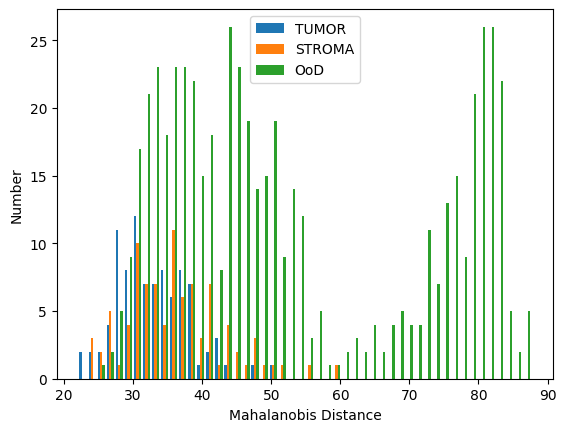

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# separate the distances for each tissue type
tumor_distances = distances_w_odd[test_labels_w_ood == 0]
stroma_distances = distances_w_odd[test_labels_w_ood == 1]
ood_distances = distances_w_odd[test_labels_w_ood == -1]
# create the histogram
plt.hist(
    [tumor_distances, stroma_distances, ood_distances],
    bins=50,
    label=["TUMOR", "STROMA", "OoD"],
)
plt.legend()
plt.xlabel("Mahalanobis Distance")
plt.ylabel("Number")
plt.show()

**Observations:**

**Task 4 (1 point)** Find a threshold on the Mahalanobis distance such that 95% of the OoD examples are filtered out. How much TUMOR and STROMA have also been filtered out?

In [11]:
### Task 4
### YOUR CODE

threshold=np.percentile(ood_distances,5)
print("Threshold", round(threshold,3))
    
    
tumor_distances_cut = tumor_distances[tumor_distances<threshold]
stroma_distances_cut = stroma_distances[stroma_distances<threshold]
ood_distances_cut = ood_distances[ood_distances<threshold]

print("TUMOR filtered out", round(100-len(tumor_distances_cut)/len(tumor_distances)*100),"%")
print("STROMA filtered out",round(100-len(stroma_distances_cut)/len(stroma_distances)*100),"%")
print("OoD filtered out",round(100-len(ood_distances_cut)/len(ood_distances)*100),"%")

Threshold 30.77
TUMOR filtered out 61 %
STROMA filtered out 74 %
OoD filtered out 95 %


**Task 5 (0.5 point)** Assign prediction -1 to filtered out examples and compute the average class-wise accuracy of your prediction with test labels (```test_labels_w_ood```). Is it satisfactory?

In [12]:
test_prediction_w_odd = predict_mahalanobis(test_features_w_ood)

test_prediction_w_odd[
    distances_w_odd >= threshold
] = -1


In [13]:
print(
    f"Accuracy TUMOR {round(100*_accuracy(test_prediction_w_odd[test_labels_w_ood==0],test_labels_w_ood[test_labels_w_ood==0]))}%"
)
print(
    f"Accuracy STROMA {round(100*_accuracy(test_prediction_w_odd[test_labels_w_ood==1],test_labels_w_ood[test_labels_w_ood==1]))}%"
)
print(
    f"Accuracy OoD {round(100*_accuracy(test_prediction_w_odd[test_labels_w_ood==-1],test_labels_w_ood[test_labels_w_ood==-1]))}%"
)
print(f"Accuracy all {round(100*_accuracy(test_prediction_w_odd,test_labels_w_ood))}%")

Accuracy TUMOR 39%
Accuracy STROMA 26%
Accuracy OoD 95%
Accuracy all 79%


In [14]:
print("number of TUMOR :", len(tumor_distances))
print("number of STROMA :", len(stroma_distances))
print("number of OoD :", len(ood_distances))

print(f"Percentage of TUMOR and STROMA: {round(100 *(len(tumor_distances) + len(stroma_distances)) / len(ood_distances))}%")

number of TUMOR : 93
number of STROMA : 93
number of OoD : 558
Percentage of TUMOR and STROMA: 33%


The above results are unsatisfactory, particularly for the two classes of interest, namely TUMOR and STROMA, as the classifier performs poorly in predicting these classes. While the overall accuracy may appear acceptable, a closer examination of each individual class reveals a lack of accuracy. Essentially, the classifier is only effective in determining whether the sample belongs to the distribution or not. This can be attributed to the unbalanced dataset, as evident from the output in the preceding cell.

### 1.3 Out-of-distribution detection with k-NN classifier (6 points)

The visual foundation models are known to be very good k-NN classifiers. It motivates us to implement a k-NN classifier to recognize TUMOR and STROMA. Moreover, k-NN distance is a good OoD-ness score and suits our task.

**Task 1 (2 points)** Based on the training features (```train_features```) and training labels (```train_labels```), classify the test features (```test_features```) using a k-NN classifier. Then report the accuracy of your predictions with the test labels (```test_labels```).

*Note:* The choice of `k` is up to you.

In [55]:
from sklearn.metrics import accuracy_score

class KNNClassifier:
    def __init__(self, k):
        self.k = k

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def get_labels(self, X_test):
        distances = torch.cdist(X_test, self.X_train) #distance euclidienne between test data and train data
        _, indices = torch.topk(distances, self.k, dim=1, largest=False) #trouve les k nearest neighbors
        knn_labels = self.y_train[indices]
        knn_labels = torch.Tensor(knn_labels) 
        return knn_labels

    def predict(self, X_test):
        knn_labels = self.get_labels(X_test)
        pred_labels, _ = torch.mode(knn_labels, dim=1) #gives most frequent label
        return pred_labels

    def get_means(self, X_test):
        knn_labels = self.get_labels(X_test)
        preds_mean = torch.mean(knn_labels, dim=1)
        return preds_mean

    def predict_means(self, X_test, thresh_1, thresh_2):
        knn_labels = self.get_labels(X_test)
        preds_mean = torch.mean(knn_labels, dim=1)
        preds_labels = -torch.ones_like(preds_mean)
        preds_labels[preds_mean <= thresh_1] = 0
        preds_labels[preds_mean >= thresh_2] = 1
        return preds_labels

knn = KNNClassifier(k=3)

In [56]:
knn.fit(train_features, train_labels)

test_pred = knn.predict(test_features)

accuracy = accuracy_score(test_labels, test_pred)
print(f'Accuracy : {100*accuracy:<.2f}%')

Accuracy : 100.00%


**Task 2 (2 points)** Perform OoD detection on the test features (```test_features_w_ood```) using a k-NN distance based OoD-ness score. Find a threshold on your OoD-ness score such that 95% of the OoD examples are filtered out. How much TUMOR and STROMA have also been filtered out? Finally, assign prediction -1 to filter out examples and compute the average class-wise accuracy of your prediction with test labels (```test_labels_w_ood```).

*Note:* The OoD-ness is based on the distance to the k-nearest neighbors. The formulation is up to you. You have to justify your choice.

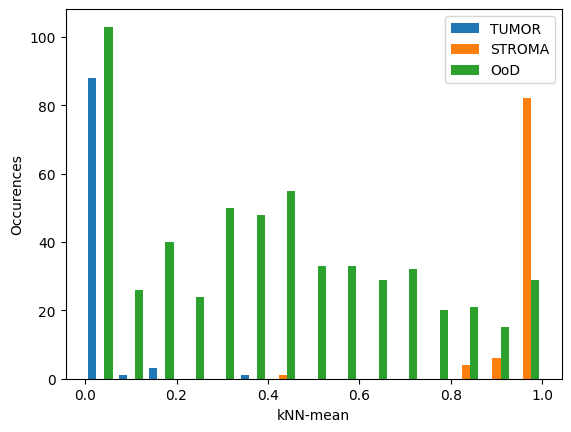

In [69]:
k = 52
knn_ood = KNNClassifier(k=k)
knn_ood.fit(train_features, train_labels)
test_pred_w_ood = knn_ood.get_means(test_features_w_ood)
ood_pred = test_pred_w_ood[test_labels_w_ood == -1]
tumor_pred = test_pred_w_ood[test_labels_w_ood == 0]
stroma_pred = test_pred_w_ood[test_labels_w_ood == 1]

plt.hist([tumor_pred, stroma_pred, ood_pred], bins=15, label=['TUMOR', 'STROMA', 'OoD'])
plt.legend()
plt.xlabel('kNN-mean')
plt.ylabel('Occurences')
plt.show()

As one can see TUMOR tend to have low values, while STROMA tend to have higher ones, as expected from a kNN-Classifier. Interestingly, the OoD seem to be in the middle. Therefore, if $d$ is the kNN-mean between two points, then $d(1-d)$ should be low for TUMOR and for STROMA and high for OoD 

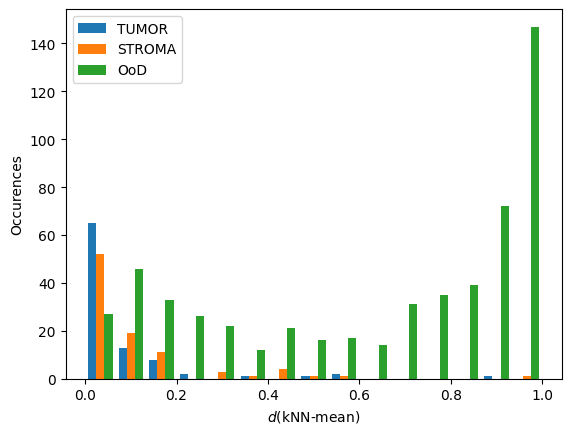

In [70]:
distance = 4 * test_pred_w_ood * (1 - test_pred_w_ood) # the 4 is just to normalize, not compulsory
ood_pred = distance[test_labels_w_ood == -1]
tumor_pred = distance[test_labels_w_ood == 0]
stroma_pred = distance[test_labels_w_ood == 1]

plt.hist([tumor_pred, stroma_pred, ood_pred], bins=15, label=['TUMOR', 'STROMA', 'OoD'])
plt.legend()
plt.xlabel('$d$(kNN-mean)')
plt.ylabel('Occurences')
plt.show()

In [71]:
threshold = 0

ood_pred_cut = ood_pred[ood_pred <= threshold]
tumor_pred_cut=tumor_pred[tumor_pred <= threshold]
stroma_pred_cut=stroma_pred[stroma_pred <= threshold]

print(f'{100*(1 - len(ood_pred_cut) / len(ood_pred)):.3g}% removed from OoD')
print(f'{100*(1 - len(tumor_pred_cut) / len(tumor_pred)):.3g}% removed from tumors')
print(f'{100*(1 - len(stroma_pred_cut) / len(stroma_pred)):.3g}% removed from stroma')

95.2% removed from OoD
30.1% removed from tumors
44.1% removed from stroma


Note that the parameter $k$ has to be at least 52 to remove 95%. For lower values of $k$, too many OoD are classified as ID. 

In [95]:
preds = -np.ones_like(test_labels_w_ood) # we fill the predictions with -1 => OoD

ID = test_features_w_ood[distance <= 0] 
# we predict using the first model the one that are ID according to our distance
preds_ID = knn.predict(ID)
preds[distance <= 0] = preds_ID

In [121]:
from sklearn.metrics import classification_report

accuracies = [100*np.mean(preds[test_labels_w_ood == i] == i) for i in [-1 ,0 ,1]]

print(f'OoD Accuracy\t: {accuracies[0]:.2f}%')
print(f'TUMOR Accuracy\t: {accuracies[1]:.2f}%')
print(f'STROMA Accuracy\t: {accuracies[2]:.2f}%')
print(f'Global Accuracy\t: {100*np.mean(test_labels_w_ood == preds):.2f}%')

OoD Accuracy	: 95.16%
TUMOR Accuracy	: 69.89%
STROMA Accuracy	: 55.91%
Global Accuracy	: 87.10%


**Task 3 (1 point)** Is k-NN better than Mahalanobis distance ? Make an hypothesis for the reasons.

**Answer:** It is apparent that the accuracy of TUMOR classification increased from 39% to 70%, STROMA from 26% to 56%, and the overall accuracy from 79% to 87%, indicating that this method is more effective for cell classification. This improvement may be attributed to the non-linear nature of the problem, which is better addressed using kNN instead of Mahalanobis distance.

**Task 4 (1 point)** Do you think we can suggest the approach presented in this exercise to compute TUMOR/STROMA ratio automatically ? Justify your thoughs. If not, suggest at least two ideas to improve it.

*Note:* Annotating all the training dataset is not an option.

**Answer:** We believe that this approach could be used if no better model is available. However, it is important to note that the model performs better at detecting TUMOR than STROMA. As a result, the TUMOR/STROMA ratio may be overestimated by a factor of approximately $1.25\ (=70\% / 56\%)$. Further analysis is required to better understand this phenomenon.

In addition, a simple idea to improve accuracy could be to combine both models to perform a classification, with each providing one transformed feature (the Mahalanobis distance and the kNN-mean, respectively). Another suggestion would be to incorporate additional features known to be relevant for TUMOR/STROMA classification. These could include morphological, textural, or contextual features, which could enhance the discriminatory power of the classification method.

---

## Part 2 (12 points)
In this part, we aim to classify cervical cells resulting from Pap smear tests. To that end we'll be using a publicly available cell dataset: Sipakmed (https://www.cs.uoi.gr/~marina/sipakmed.html). The dataset is composed of 4049 images of isolated cells cropped from 966 cluster cell images of Pap smear slides. Each cell in the dataset has been categorized in either of the following categories: 

    - Superficial-Intermediate.
    - Parabasal.
    - Koilocytotic.
    - Dysketarotic.
    - Metaplastic.
Your objective is to implement a classifier to automate the cell classification process. To ease your work we provide you with pre-computed embeddings for each images (`lab-03-data/part2/sipakmed_clean_embeddings.pth`). The embeddings are obtained from a pre-trained ResNet-50 (https://arxiv.org/pdf/1512.03385.pdf) and the corresponding images are also provided (`lab-03-data/part2/sipakmed_clean`). Note that you are free to discard the provided embeddings and work directy with the images.

### 2.1 Dataset (4 points)
Your first task is prepare the dataset such that it can be used to train your model. For that purpose we prepared the skeleton of the class `Sipakmed` that inherits from the class `Dataset` of PyTorch. Read the documentation (https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files) and complete the missing parts.

In [122]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image
from torch import nn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

torch.manual_seed(2)

In [123]:
# Load the features
features_path = '../data/lab-03-data/part2/sipakmed_clean_embeddings.pth'

In [124]:
class Sipakmed(Dataset):
    phase_dict = {
        "train": {"start": 0.0, "stop": 0.5},
        "val": {"start": 0.5, "stop": 0.75},
        "test": {"start": 0.75, "stop": 1.0},
    }
    label_dict = {
        "im_Superficial-Intermediate": 0,
        "im_Parabasal": 1,
        "im_Metaplastic": 2,
        "im_Koilocytotic": 3,
        "im_Dyskeratotic": 4,
    }

    def __init__(self, features_path, phase):
        super(Sipakmed, self).__init__()
        # Store class attributes
        self.phase = phase

        # Collect the dataimport torch
        import torch.nn.functional as F
        import numpy as np

        self.raw_data = torch.load(features_path)
        self.features, self.labels, self.paths = self.collect_data()

    def collect_data(self):
        # Iterate over the dirs/classes
        features, labels, paths = [], [], []
        for _, dir_dict in self.raw_data.items():
            # Get the paths and embeddings
            dir_paths, dir_embeddings = list(
                zip(*[(k, v) for k, v in dir_dict.items()])
            )

            # Split
            n = len(dir_paths)
            np.random.seed(42)
            permutations = np.random.permutation(n)
            dir_paths = np.array(dir_paths)[permutations]
            dir_embeddings = torch.stack(dir_embeddings)[permutations]
            n_start = int(n * self.phase_dict[self.phase]["start"])
            n_stop = int(n * self.phase_dict[self.phase]["stop"])
            dir_embeddings = dir_embeddings[n_start:n_stop]
            dir_paths = dir_paths[n_start:n_stop]

            # Store
            features.append(dir_embeddings)
            paths.append(dir_paths)
            dir_labels = torch.tensor(
                [self.label_dict[p.split("/")[-2]] for p in dir_paths]
            )
            labels.append(dir_labels)

        # Merge
        features = torch.cat(features)
        labels = torch.cat(labels)
        paths = np.concatenate(paths)
        return features, labels, paths

    def __len__(self):
        """
        Returns the number of samples in the dataset.
        """
        ### YOUR CODE
        return len(self.labels)

    def __getitem__(self, index):
        """
        Returns the embedding, label, and image path of queried index.
        """
        ### YOUR CODE
        embedding, label, path = (
            self.features[index],
            self.labels[index],
            self.paths[index],
        )

        return embedding, label, path

Once the implementation of `Sipakmed` completed, create 3 instances of the class (train/val/test) with the corresponding `phase` flag.

In [125]:
# Instantiate the datasets
train_dataset = Sipakmed(features_path, "train")
val_dataset = Sipakmed(features_path, "val")
test_dataset = Sipakmed(features_path, "test")

Now that your datasets are ready, use the class `DataLoader` from PyTorch to let it handle efficiently the batching, shuffling, etc. of your data.

In [126]:
# Instantiate the data loaders
train_loader = DataLoader(train_dataset,batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=128, shuffle=True)

Get to know your data. Plot a few example images for each class of your dataset.

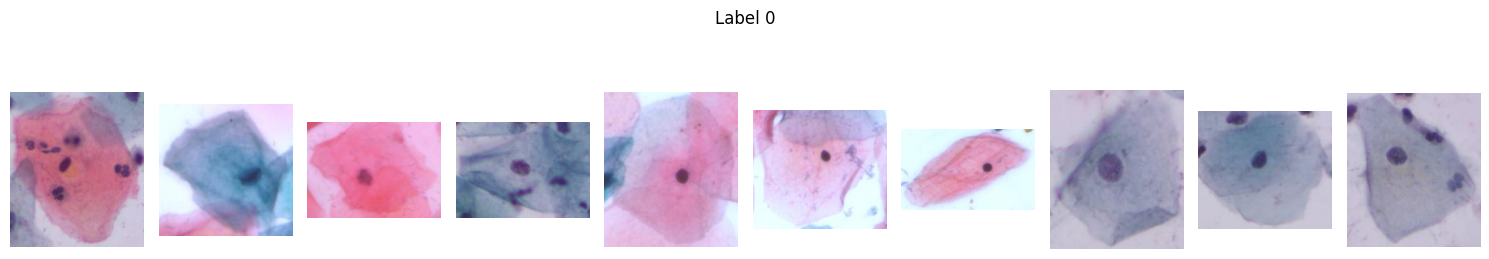

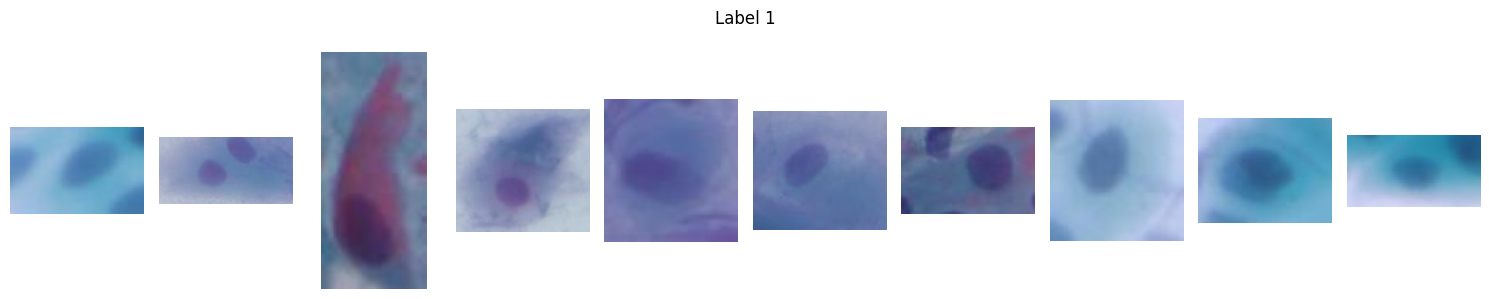

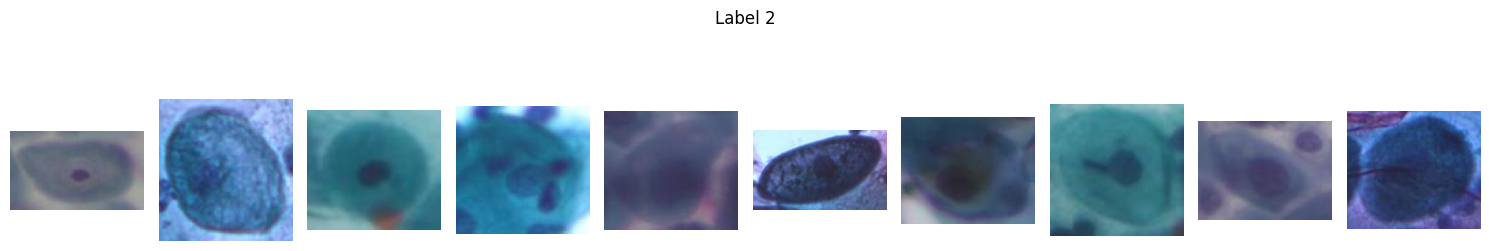

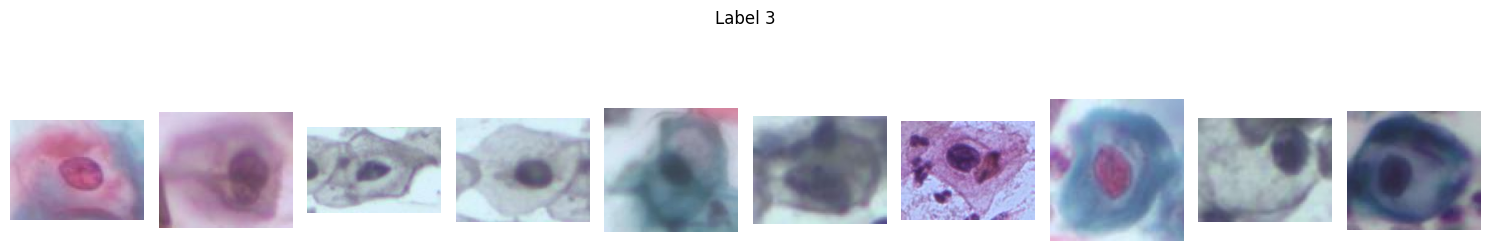

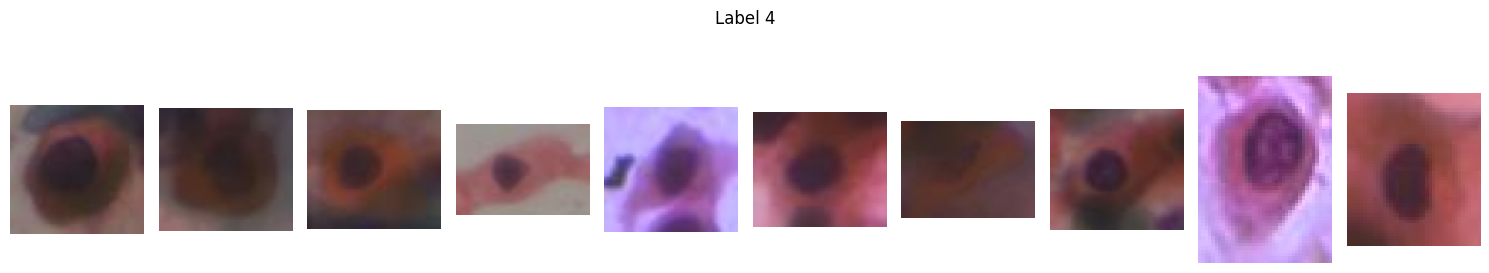

In [127]:
# Visualize some training example
from random import sample, seed

seed(42)

n = 10
labels = np.unique(train_dataset.labels)

for label in labels:
    fig, ax = plt.subplots(1, n, figsize=(15, 3))
    fig.suptitle(f"Label {label}")
    indexes = np.where(train_dataset.labels == label)[0]
    index = sample(sorted(indexes),n)
    for i, ind in enumerate(index):
        path = train_dataset[ind][2]
        ax[i].imshow(Image.open(f"../data/lab-03-data/part2/{path}"))
        ax[i].axis('off')
    plt.tight_layout()

### 2.2 Training (4 points)
In this part your objective is to implement the required tools to train your model. The first thing you'll need is a a model which takes as input the pre-computed features and returns the corresponding class probabilities/logits.

In [128]:
# Implement the model
embedding_dim = train_dataset.features.shape[1]
model = nn.Sequential(
          nn.Linear(embedding_dim,1024),
          nn.ReLU(),
          nn.Linear(1024,512),
          nn.ReLU(),
          nn.Linear(512,256),
          nn.ReLU(),
          nn.Linear(256,128),
          nn.ReLU(),
          nn.Linear(128,len(np.unique(test_dataset.labels))),    
        )

The optimizer will keep track of your model's parameters, gradients, etc (https://pytorch.org/docs/stable/optim.html). It is responsible to update your model's parameters after each forward pass using the backpropagation algorithm.

In [129]:
# Set the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [130]:
# Set the loss
criterion = torch.nn.CrossEntropyLoss()

Implement a function that takes as input the model's output and the corresponding labels and returns the perçentage of correct predictions.

In [131]:
def accuracy(outputs, labels):
    """
    Computes the accuracy of predictions based on the model outputs (NxK: N samples, K classes) 
    and the labels (N: N samples).
    """
    return torch.sum(torch.eq(outputs, labels))/len(labels)

Implement a funtion `train` that forwards the complete training set through your model (= 1 epoch) and updates its parameters after each forward pass. To keep track of the training process make sure to at least return the accuracy of the model and the average loss it incurred through the current epoch.

In [132]:
def train(model, optimizer, criterion, loader):
    # Set the model in train mode
    ### YOUR CODE
    
    # Iterate over the batches
    full_outputs = []
    full_labels = []
    losses = []
    for batch in loader:
        # Get the embeddings, labels and paths 
        ### YOUR CODE
        embeddings, labels, _ = batch
        
        # Feed the embeddings to the model
        ### YOUR CODE
        outputs = model(embeddings)

        # Compute cross entropy loss
        ### YOUR CODE
        loss = criterion(outputs, labels)
        
        # Reset the gradients
        ### YOUR CODE
        optimizer.zero_grad()
        
        # Backpropagate
        ### YOUR CODE
        loss.backward()

        # Update the parameters
        ### YOUR CODE
        optimizer.step()     
        
        # Store the outputs, labels and loss
        ### YOUR CODE
        full_labels.append(labels)
        full_outputs.append(torch.argmax(outputs,dim=1))
        losses.append(loss)
    
    # Concat
    full_outputs = torch.cat(full_outputs).cpu()
    full_labels = torch.cat(full_labels).cpu()
    losses = torch.stack(losses).mean().cpu()
    
    # Compute the accuracy
    ### YOUR CODE
    acc = accuracy(full_outputs,full_labels)
    return acc, full_outputs, full_labels, losses

Implement a funtion `validate` that forwards the complete validation or test set through your model and evaluates its predictions. To keep track of the training process make sure to at least return the accuracy of the model and the average loss it incurred through the current epoch.

In [133]:
@torch.no_grad()
def validate(model, criterion, loader):
    # Set the model in train mode
    ### YOUR CODE
    model.eval()
    
    # Iterate over the batches
    full_outputs = []
    full_labels = []
    full_paths = []
    losses = []
    for batch in loader:
        # Get the embeddings, labels and paths
        ### YOUR CODE
        embeddings, labels, path = batch
        
        # Feed the embeddings to the model
        ### YOUR CODE
        outputs = model(embeddings)

        # Compute cross entropy loss
        ### YOUR CODE
        loss = criterion(outputs,labels)
        
        # Store the outputs, labels and loss
        ### YOUR CODE
        full_labels.append(labels)
        full_outputs.append(torch.argmax(outputs,dim=1))
        full_paths.append(path)
        losses.append(loss)
     
    
    # Concat
    full_outputs = torch.cat(full_outputs).cpu()
    full_labels = torch.cat(full_labels).cpu()
    losses = torch.stack(losses).mean().cpu()
    full_paths = np.concatenate(full_paths)
    
    # Compute the accuracy
    acc= accuracy(full_outputs,full_labels)
    return acc, full_outputs, full_labels, losses, full_paths

You should now be able to train you model. Alternate between training and validation steps to find and save the best model (best accuracy on the validation set).

In [134]:
# Main loop
epochs = 30
best_acc = 0
model_savepath = '../data/model'
loss_total = []
acc_total = []

for epoch in range(epochs):
    # Train
    ### YOUR CODE
    loss_total.append(train(model, optimizer, criterion, train_loader)[3])
    

    # Evaluate
    ### YOUR CODE
    val_acc = validate(model, criterion, val_loader)[0]
    acc_total.append(val_acc)
    
    # Save the model
    if val_acc > best_acc:
        ### YOUR CODE
        best_acc = val_acc
        torch.save(model.state_dict(), model_savepath)

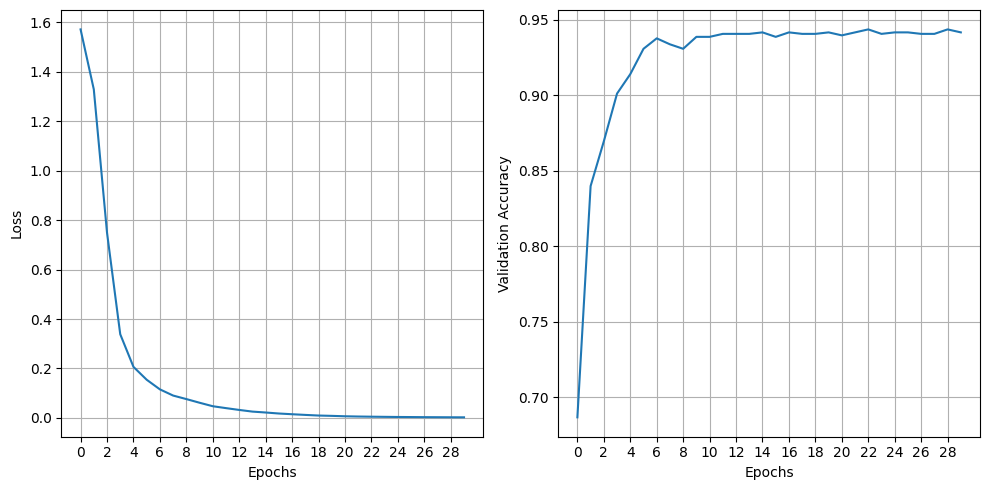

In [135]:
_,(ax1,ax2)=plt.subplots(1,2, figsize=(10,5))

losses = torch.stack(loss_total)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.plot(losses.detach().numpy())
ax1.set_xticks(range(0,epochs,2))
ax1.grid()

ax2.plot(acc_total)
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Validation Accuracy")
ax2.set_xticks(range(0,epochs,2))
ax2.grid()

plt.tight_layout()

### 2.3 Evaluation (4 points)
Re-load the best model and evaluate its predictions on the test set.

In [136]:
# Re-load the best model
### YOUR CODE
model.load_state_dict(torch.load(model_savepath))

# Evaluate
### YOUR CODE
acc, predictions, labels, _, paths = validate(model, criterion, test_loader)
print(f"Accuracy {round(acc.item(),2)*100}%")

Accuracy 95.0%


A useful tool to analyze your model's performance on the different classes is the confusion matrix (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html). Computes its entries for your model and the test set.

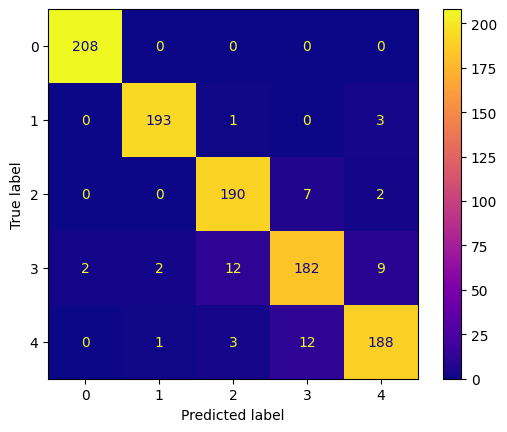

In [137]:
# Display the confusion matrix
### YOUR CODE
disp = ConfusionMatrixDisplay(confusion_matrix(labels,predictions))
disp.plot(cmap="plasma")

Alternatively it can be useful to plot the problematic samples as well as the predicted and ground truth classes. Can you do so?

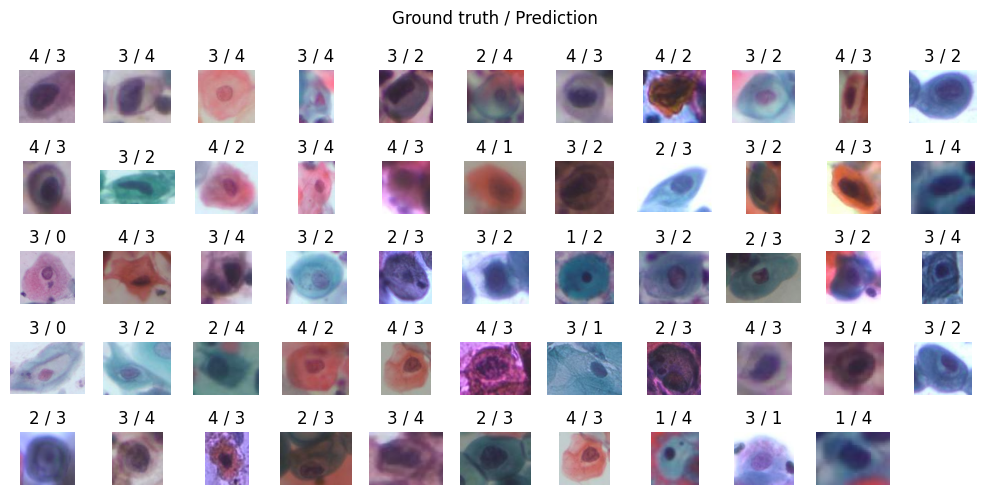

In [138]:
# Find the misclassified samples
### YOUR CODE
misclassified_path = paths[torch.where(~labels.eq(predictions))]
misclassified_labels = labels[torch.where(~labels.eq(predictions))]
misclassified_pred = predictions[torch.where(~labels.eq(predictions))]

fig, axes = plt.subplots(5,len(misclassified_path)//5+1, figsize=(10,5))

# Plot the misclassified samples
### YOUR CODE
fig.suptitle("Ground truth / Prediction")
for i,(ax,path) in enumerate(zip(axes.ravel(), misclassified_path)):
    ax.imshow(Image.open(f'../data/lab-03-data/part2/{path}'))
    ax.set_title(f"{misclassified_labels[i].item()} / {misclassified_pred[i].item()}" )
    
for ax in axes.ravel():
    ax.axis("off")
    
plt.tight_layout()